#Importar data de pacientes

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#Filtrado del dataset:Selección de características más relevantes


In [2]:
!gdown 1C4IyUGc8YtKmmY1e7QP4T-6c10E8Nms-

df_filt1=pd.read_csv('df_filt1.csv')
df_filt1

Downloading...
From: https://drive.google.com/uc?id=1C4IyUGc8YtKmmY1e7QP4T-6c10E8Nms-
To: /content/df_filt1.csv
100% 465k/465k [00:00<00:00, 21.8MB/s]


,subject_id,weight,height,age,Anestesia_TIME,Operation_TIME,UCI_TIME,Survival Rate,rr_mean,spo2_mean,...,pip_max,hr_max,art_dbp_max,art_mbp_max,etco2_max,fio2_max,hs_max,uo_max,ebl_max,peep_max
0,192250700,59.0,163.0,65,380.0,340.0,2345.0,0,9.519231,99.215190,...,28.0,108.0,68.0,88.0,35.0,95.0,700.0,500.0,500.0,5.0
1,144893612,63.0,174.0,40,175.0,140.0,1930.0,0,15.027778,95.000000,...,23.0,108.0,0.0,0.0,41.0,91.0,400.0,50.0,40.0,0.0
2,118515241,46.0,146.0,85,180.0,100.0,3770.0,0,10.569444,99.729730,...,23.0,108.0,82.0,114.0,37.0,0.0,400.0,120.0,40.0,1.0
3,131682281,56.0,156.0,30,195.0,165.0,0.0,0,9.085714,100.000000,...,15.0,74.0,82.0,106.0,35.0,58.0,550.0,90.0,150.0,3.0
4,192170760,64.0,162.0,35,125.0,100.0,0.0,0,9.596154,99.444444,...,19.0,88.0,0.0,0.0,35.0,95.0,550.0,20.0,150.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,186132074,49.0,146.0,80,185.0,115.0,0.0,0,10.565789,99.447368,...,19.0,76.0,68.0,106.0,39.0,97.2,0.0,20.0,300.0,7.0
1162,192891843,64.0,158.0,50,115.0,85.0,0.0,0,9.847826,99.375000,...,16.0,108.0,88.0,114.0,35.0,76.0,400.0,50.0,100.0,5.0
1163,173675824,75.0,160.0,25,115.0,70.0,0.0,0,10.782609,99.280000,...,23.0,100.0,64.0,86.0,35.0,97.2,0.0,0.0,40.0,3.0
1164,178121234,60.0,158.0,70,255.0,215.0,0.0,0,10.673077,99.849057,...,14.0,64.0,72.0,98.0,39.0,97.2,200.0,70.0,100.0,4.0


In [3]:
# Crear una copia de la columna
df1 = df_filt1[['UCI_TIME']].copy()

# Clasificar los valores según las condiciones (De 0 a 7000 : tiempo corto(0),De  7000 a 14000 -tiempo mediano(1)- Mayor a 14000-tiempo largo en UCI (2)
df1['UCI_TIME'] = df1['UCI_TIME'].apply(lambda x: 0 if x <= 7000 else (1 if x <= 14000 and x>7000 else 2))

# Mostrar el DataFrame resultante
conteo1=df1['UCI_TIME'].value_counts()
conteo1

#new_df = operation_pac[['subject_id','icuin_time', 'icuout_time', 'inhosp_death_time']].copy()
#difference=(operation_pac['icuout_time'] - operation_pac['icuin_time'])

UCI_TIME
0    1098
2      35
1      33
Name: count, dtype: int64

#Modelos ML

In [4]:
# Preparación de los datos
X = df_filt1.drop(columns=['UCI_TIME', 'Survival Rate', 'subject_id','weight','height','age','Anestesia_TIME','Operation_TIME'])
#X = df_filt1.drop(columns=['UCI_TIME', 'Survival Rate', 'subject_id'])
y = df1['UCI_TIME']

# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


########################################
# Crear una tubería que combine SMOTE y RandomUnderSampler
over = SMOTE(sampling_strategy={1: 150, 2:100}, random_state=42, k_neighbors=2)
under = RandomUnderSampler(sampling_strategy={0: 200}, random_state=42)
pipeline = Pipeline(steps=[('o', over), ('u', under)])


# Aplicar la tubería a los datos
X_resampled, y_resampled = pipeline.fit_resample(X_scaled, y)

# Convertir las etiquetas a formato categórico
y_categorical = to_categorical(y_resampled, num_classes=3)
######################################
# Aplicar SMOTE Tomek para sobremuestrear las clases minoritarias y limpiar los ejemplos
#smote_tomek = SMOTETomek(sampling_strategy='auto', random_state=42, smote=SMOTE(k_neighbors=2))
#X_resampled, y_resampled = smote_tomek.fit_resample(X_scaled, y)

# Convertir las etiquetas a formato categórico
#y_categorical = to_categorical(y_resampled, num_classes=3)
########################################

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_categorical, test_size=0.2, random_state=0)

In [5]:

# Mostrar el DataFrame resultante
conteo=y_resampled.value_counts()
conteo

UCI_TIME
0    200
1    150
2    100
Name: count, dtype: int64

Claves de roc_curves: ['KNeighbors Class 0', 'KNeighbors Class 1', 'KNeighbors Class 2', 'SVC Class 0', 'SVC Class 1', 'SVC Class 2', 'DecisionTree Class 0', 'DecisionTree Class 1', 'DecisionTree Class 2', 'RandomForest Class 0', 'RandomForest Class 1', 'RandomForest Class 2', 'GradientBoosting Class 0', 'GradientBoosting Class 1', 'GradientBoosting Class 2', 'XGBoost Class 0', 'XGBoost Class 1', 'XGBoost Class 2']


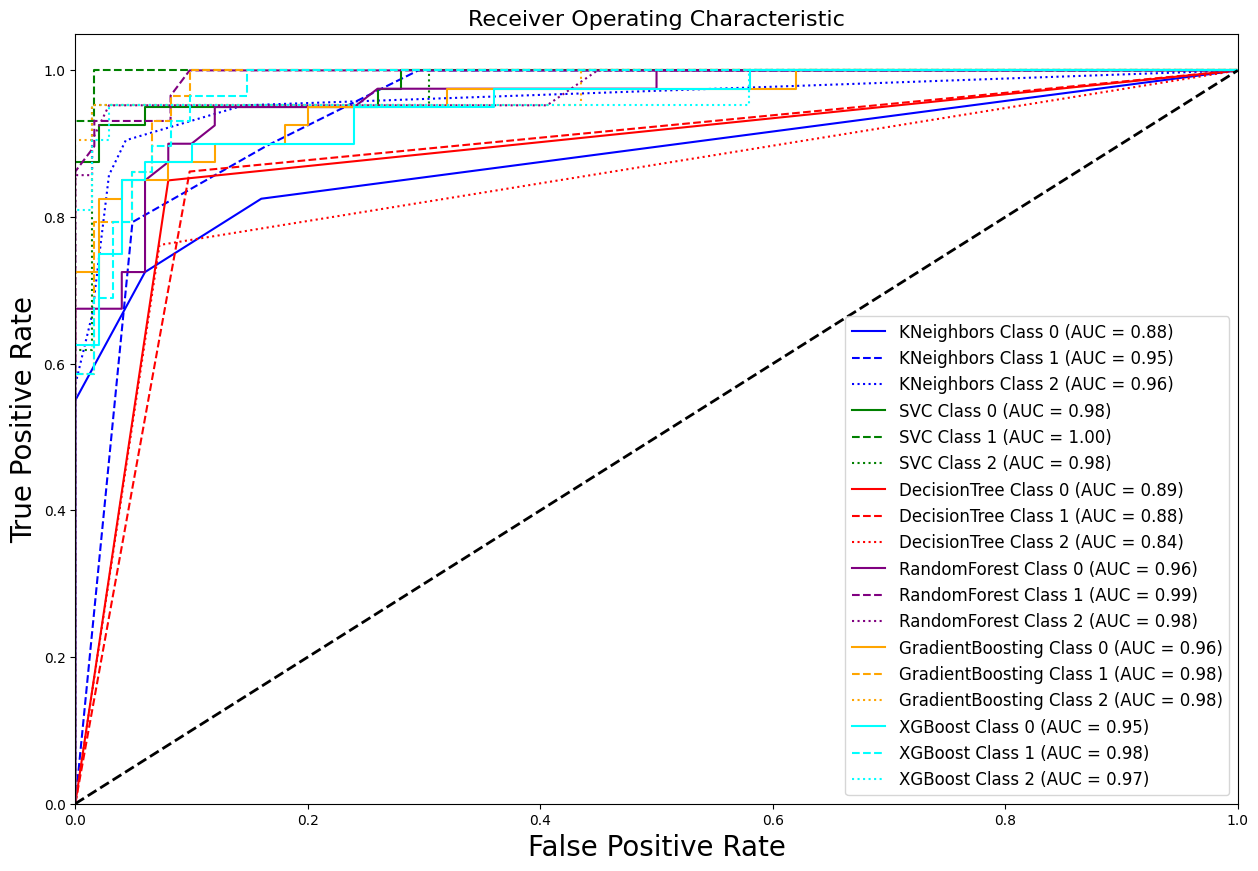

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, auc as sklearn_auc

#Invertir la categorización de las etiquetas para el cálculo de métricas
y_train_inversed = np.argmax(y_train, axis=1)
y_test_inversed = np.argmax(y_test, axis=1)

# Inicializar modelos
models = {
    'KNeighbors': KNeighborsClassifier(),
    'SVC': SVC(probability=True),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Entrenar los modelos
for name, model in models.items():
    model.fit(X_train, y_train_inversed)

# Función para calcular NPV
def npv_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0, 0]
    FN = cm[1, 0]
    return TN / (TN + FN) if (TN + FN) > 0 else np.nan

# Función para calcular Specificity
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    return TN / (TN + FP) if (TN + FP) > 0 else np.nan

# Inicializar la lista de resultados
results = []
confusion_matrices = {}
roc_curves = {}

# Calcular métricas para cada modelo y clase
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    # Guardar la matriz de confusión para su visualización posterior
    confusion_matrices[name] = confusion_matrix(y_test_inversed, y_pred)

    classes = np.unique(y_train_inversed)
    for i in classes:
        y_true_binary = (y_test_inversed == i).astype(int)
        y_pred_binary = (y_pred == i).astype(int)

        accuracy = accuracy_score(y_true_binary, y_pred_binary) * 100
        sensitivity = recall_score(y_true_binary, y_pred_binary) * 100
        specificity = specificity_score(y_true_binary, y_pred_binary) * 100
        f1 = f1_score(y_true_binary, y_pred_binary) * 100
        auc = roc_auc_score(y_true_binary, y_prob[:, i]) * 100 if y_prob is not None else np.nan

        results.append([f'{name} Class {i}', accuracy, sensitivity, specificity, f1, auc])

        # Calcular la curva ROC
        if y_prob is not None:
            fpr, tpr, _ = roc_curve(y_true_binary, y_prob[:, i])
            roc_auc = sklearn_auc(fpr, tpr)
            roc_curves[f'{name} Class {i}'] = (fpr, tpr, roc_auc)

    # Calcular promedios
    metrics = np.array([result[1:] for result in results if result[0].startswith(name)])
    average_metrics = np.mean(metrics, axis=0)
    results.append([f'{name} Average', *average_metrics])

# Crear el DataFrame
df = pd.DataFrame(results, columns=['Model', 'Accuracy (%)', 'Sensitivity or recall (%)', 'Specificity (%)', 'F1-Score (%)', 'AUC (%)'])

import matplotlib.pyplot as plt

# Inspeccionar las claves de roc_curves para entender su formato
print("Claves de roc_curves:", list(roc_curves.keys()))

# Lista de colores para cada modelo
model_colors = {
    'KNeighbors': 'blue',
    'SVC': 'green',
    'DecisionTree': 'red',
    'RandomForest': 'purple',
    'GradientBoosting': 'orange',
    'XGBoost': 'cyan'
}

# Estilos de línea para cada clase
line_styles = {
    0: 'solid',
    1: 'dashed',
    2: 'dotted'
}

# Visualizar las curvas ROC
plt.figure(figsize=(15, 10))
for key, (fpr, tpr, roc_auc) in roc_curves.items():
    # Verificar el formato de la clave
    if 'Class' in key:
        model_name, class_label = key.rsplit(' Class ', 1)
        class_label = int(class_label)
        color = model_colors.get(model_name, 'black')
        linestyle = line_styles.get(class_label, 'solid')
        plt.plot(fpr, tpr, color=color, linestyle=linestyle, label=f'{key} (AUC = {roc_auc:.2f})')
    else:
        print(f"Formato inesperado en la clave: {key}")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Receiver Operating Characteristic', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.show()

In [7]:
df

,Model,Accuracy (%),Sensitivity or recall (%),Specificity (%),F1-Score (%),AUC (%)
0,KNeighbors Class 0,81.111111,57.500000,100.000000,73.015873,88.225000
1,KNeighbors Class 1,80.000000,100.000000,70.491803,76.315789,94.573205
2,KNeighbors Class 2,94.444444,85.714286,97.101449,87.804878,96.169772
3,KNeighbors Average,85.185185,81.071429,89.197751,79.045514,92.989326
4,SVC Class 0,93.333333,85.000000,100.000000,91.891892,98.400000
5,SVC Class 1,92.222222,100.000000,88.524590,89.230769,99.886942
6,SVC Class 2,96.666667,90.476190,98.550725,92.682927,98.067633
7,SVC Average,94.074074,91.825397,95.691772,91.268529,98.784858
8,DecisionTree Class 0,88.888889,85.000000,92.000000,87.179487,88.500000
9,DecisionTree Class 1,88.888889,86.206897,90.163934,83.333333,88.185415


In [8]:
# Exportar a un archivo CSV
df.to_csv('df_resultados.csv', index=False)

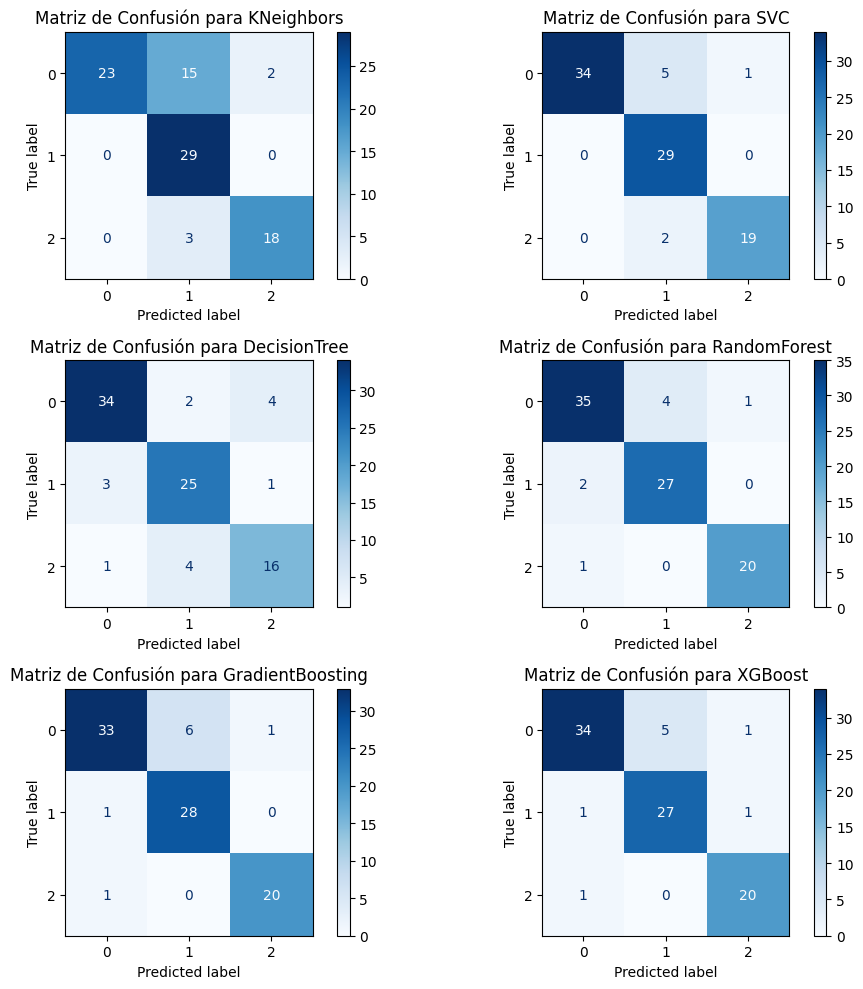

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Generar y mostrar las matrices de confusión en subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for idx, (name, cm) in enumerate(confusion_matrices.items()):
    row = idx // 2
    col = idx % 2
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train_inversed))
    disp.plot(cmap='Blues', ax=axes[row, col])
    axes[row, col].set_title(f'Matriz de Confusión para {name}')
    axes[row, col].grid(False)

plt.tight_layout()
plt.show()

In [10]:
confusion_matrices

{'KNeighbors': array([[23, 15,  2],
        [ 0, 29,  0],
        [ 0,  3, 18]]),
 'SVC': array([[34,  5,  1],
        [ 0, 29,  0],
        [ 0,  2, 19]]),
 'DecisionTree': array([[34,  2,  4],
        [ 3, 25,  1],
        [ 1,  4, 16]]),
 'RandomForest': array([[35,  4,  1],
        [ 2, 27,  0],
        [ 1,  0, 20]]),
 'GradientBoosting': array([[33,  6,  1],
        [ 1, 28,  0],
        [ 1,  0, 20]]),
 'XGBoost': array([[34,  5,  1],
        [ 1, 27,  1],
        [ 1,  0, 20]])}

#Analisis usando SHAP

In [11]:
df_shap=df_filt1.drop(columns=['Survival Rate','UCI_TIME','subject_id']).copy()
df_concat_shap = pd.concat([df_shap,df1],axis=1)
df_concat_shap

,weight,height,age,Anestesia_TIME,Operation_TIME,rr_mean,spo2_mean,o2_mean,air_mean,minvol_mean,...,hr_max,art_dbp_max,art_mbp_max,etco2_max,fio2_max,hs_max,uo_max,ebl_max,peep_max,UCI_TIME
0,59.0,163.0,65,380.0,340.0,9.519231,99.215190,3.233333,0.260000,4.046154,...,108.0,68.0,88.0,35.0,95.0,700.0,500.0,500.0,5.0,0
1,63.0,174.0,40,175.0,140.0,15.027778,95.000000,3.300000,0.333333,8.423529,...,108.0,0.0,0.0,41.0,91.0,400.0,50.0,40.0,0.0,0
2,46.0,146.0,85,180.0,100.0,10.569444,99.729730,4.300000,1.500000,3.822222,...,108.0,82.0,114.0,37.0,0.0,400.0,120.0,40.0,1.0,0
3,56.0,156.0,30,195.0,165.0,9.085714,100.000000,2.233333,0.333333,3.462857,...,74.0,82.0,106.0,35.0,58.0,550.0,90.0,150.0,3.0,0
4,64.0,162.0,35,125.0,100.0,9.596154,99.444444,2.233333,0.650000,4.107692,...,88.0,0.0,0.0,35.0,95.0,550.0,20.0,150.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,49.0,146.0,80,185.0,115.0,10.565789,99.447368,3.250000,1.500000,3.091892,...,76.0,68.0,106.0,39.0,97.2,0.0,20.0,300.0,7.0,0
1162,64.0,158.0,50,115.0,85.0,9.847826,99.375000,3.250000,1.500000,3.872727,...,108.0,88.0,114.0,35.0,76.0,400.0,50.0,100.0,5.0,0
1163,75.0,160.0,25,115.0,70.0,10.782609,99.280000,3.350000,1.500000,4.313043,...,100.0,64.0,86.0,35.0,97.2,0.0,0.0,40.0,3.0,0
1164,60.0,158.0,70,255.0,215.0,10.673077,99.849057,3.250000,1.500000,5.615385,...,64.0,72.0,98.0,39.0,97.2,200.0,70.0,100.0,4.0,0


In [12]:
!pip install shap
import shap

               SHAP_value
ebl              9.168599
hr               8.885709
fio2              8.84328
pip              8.580446
hs               7.136899
rr               5.796333
minvol           4.752851
vt               4.584628
spo2             4.479769
etco2            2.912554
age              2.760277
air              2.623297
o2               2.315172
peep             2.268197
art_mbp          2.238162
art_dbp          1.919599
uo               1.887473
Operation_TIME    1.85637
Anestesia_TIME   1.723835
weight           1.209391
height           0.923054


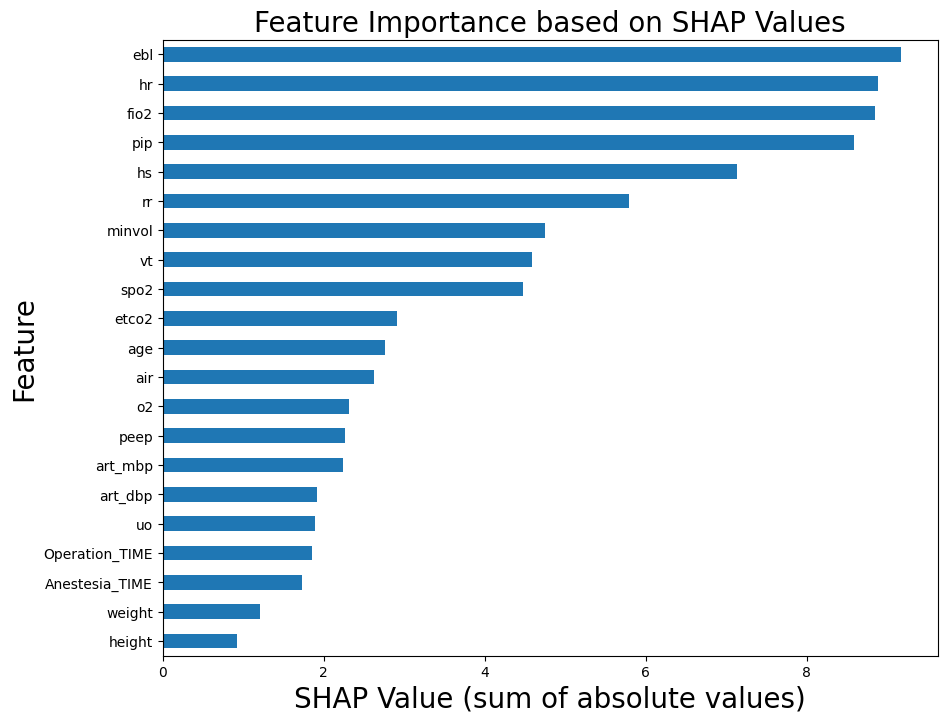

In [13]:
# X contiene todas las características, y contiene la variable objetivo UCI_TIME
X = df_concat_shap.drop(columns=['UCI_TIME'])
y = df_concat_shap['UCI_TIME']

# Convertir y a un array 1D si es necesario
y = y.values.ravel()

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar un modelo de RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Crear un objeto SHAP explainer usando el modelo entrenado
explainer = shap.TreeExplainer(model)

# Calcular los valores SHAP para el conjunto de prueba
shap_values = explainer.shap_values(X_test)

# Si hay múltiples clases, promediamos los valores SHAP para obtener una sola métrica por característica
if isinstance(shap_values, list):
    shap_values = np.mean(np.abs(shap_values), axis=0)

# Listas de características con sus sufijos
valores_unicos2 = ['rr', 'spo2', 'o2', 'air', 'minvol', 'vt', 'pip', 'hr', 'art_dbp', 'art_mbp', 'etco2', 'fio2', 'hs', 'uo', 'ebl', 'peep']
valores_mean = [f"{valor}_mean" for valor in valores_unicos2]
valores_min = [f"{valor}_min" for valor in valores_unicos2]
valores_max = [f"{valor}_max" for valor in valores_unicos2]

# Características adicionales
additional_features = ['weight', 'height', 'age', 'Anestesia_TIME', 'Operation_TIME']

# Crear un DataFrame para almacenar la suma de los valores SHAP para cada característica
shap_importance = pd.DataFrame(index=valores_unicos2 + additional_features, columns=['SHAP_value'])

# Sumar los valores SHAP correspondientes a la misma característica a través de las diferentes estadísticas
for feature in valores_unicos2:
    shap_importance.loc[feature, 'SHAP_value'] = (
        np.abs(shap_values[:, X_test.columns.get_loc(f"{feature}_mean")]).sum() +
        np.abs(shap_values[:, X_test.columns.get_loc(f"{feature}_min")]).sum() +
        np.abs(shap_values[:, X_test.columns.get_loc(f"{feature}_max")]).sum()
    )

# Agregar los valores SHAP de las características adicionales
for feature in additional_features:
    shap_importance.loc[feature, 'SHAP_value'] = np.abs(shap_values[:, X_test.columns.get_loc(feature)]).sum()

# Ordenar las características por importancia
shap_importance = shap_importance.sort_values(by='SHAP_value', ascending=False)

# Mostrar la importancia de las características
print(shap_importance)


shap_importance.plot(kind='barh', figsize=(10, 8), legend=False)
plt.xlabel('SHAP Value (sum of absolute values)', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.title('Feature Importance based on SHAP Values', fontsize=20)
plt.gca().invert_yaxis()  # Para que las características más importantes estén arriba
plt.show()

#Análsis de las caracteristicas

In [14]:
X = df_filt1.drop(columns=['UCI_TIME', 'Survival Rate', 'subject_id'])
y = df1['UCI_TIME']


# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Aplicar SMOTE Tomek para sobremuestrear las clases minoritarias y limpiar los ejemplos
smote_tomek = SMOTETomek(sampling_strategy='auto', random_state=42, smote=SMOTE(k_neighbors=2))
X_resampled, y_resampled = smote_tomek.fit_resample(X_scaled, y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled, test_size=0.2, random_state=0)

# Clasificación con SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       224
           1       0.92      1.00      0.96       226
           2       0.97      1.00      0.98       209

    accuracy                           0.96       659
   macro avg       0.96      0.96      0.96       659
weighted avg       0.96      0.96      0.96       659



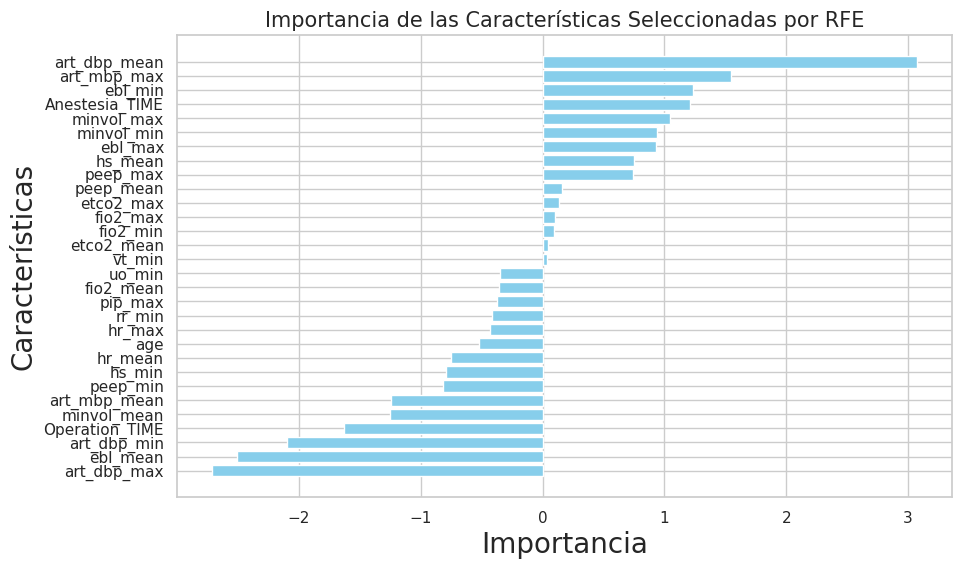

In [17]:


from sklearn.feature_selection import RFE


# Aplicar RFE
rfe = RFE(estimator=svm_model, n_features_to_select=30)  # Puedes ajustar el número de características
rfe.fit(X_train, y_train)

# Características seleccionadas e importancias
selected_features = X.columns[rfe.support_]
feature_importances = rfe.estimator_.coef_[0]

# Crear un DataFrame para las características seleccionadas y sus importancias
importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importances})

# Ordenar el DataFrame por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Gráfica de barras de la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importancia', fontsize=20)
plt.ylabel('Características',fontsize=20)
plt.title('Importancia de las Características Seleccionadas por RFE',fontsize=15)
plt.gca().invert_yaxis()
plt.show()

<ipython-input-16-fe4fc0678ac3>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


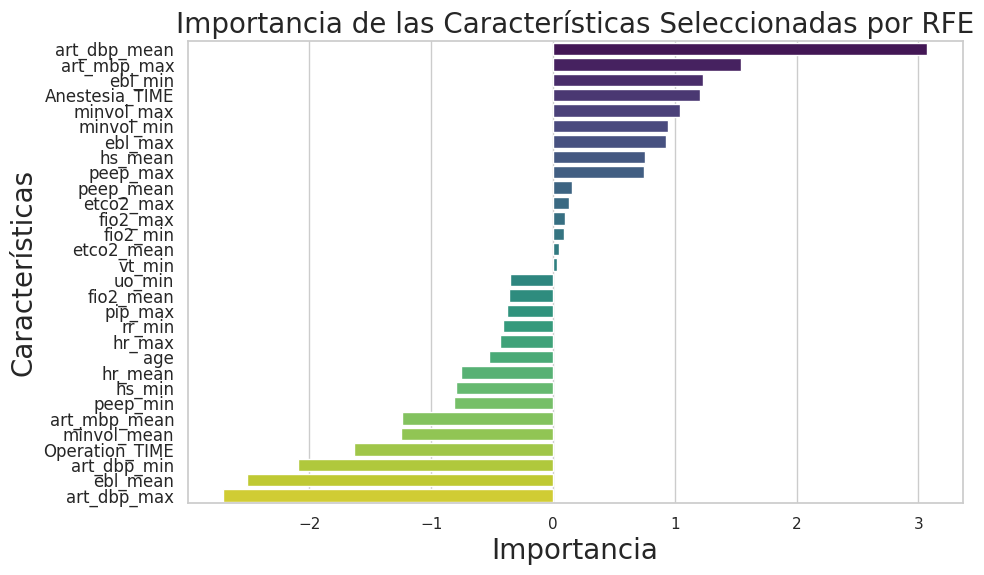

In [16]:
import seaborn as sns
sns.set(style="whitegrid")
# Crear un DataFrame para las características seleccionadas y sus importancias
importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importances})

# Ordenar el DataFrame por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Configurar el estilo y la paleta de colores de seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Crear gráfico de barras con seaborn
bar_plot = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')

# Añadir etiquetas y título
plt.xlabel('Importancia',fontsize=20)
plt.ylabel('Características',fontsize=20)
plt.title('Importancia de las Características Seleccionadas por RFE',fontsize=20)

# Mejorar la visibilidad de las etiquetas del eje y
for item in bar_plot.get_yticklabels():
    item.set_fontsize(12)

# Mostrar el gráfico
plt.show()
